In [57]:
from PIL import Image
import numpy as np
import scipy.io.wavfile as wav
import pyofdm.codec
import pyofdm.nyquistmodem
import matplotlib.pyplot as plt

In [58]:
from reedsolo import RSCodec
from reedsolo import ReedSolomonError

N, K = 255, 223
rsc = RSCodec(N-K, nsize=N)

In [59]:
tx_im = Image.open("DC4_300x200.pgm")
tx_byte = np.append(np.array(tx_im, dtype="uint8").flatten(),
                    np.zeros(K-tx_im.size[1]*tx_im.size[0]%K, dtype="uint8"))
tx_enc = np.empty(0, "uint8")
for i in range(0, tx_im.size[1]*tx_im.size[0], K):
    tx_enc = np.append(tx_enc, np.uint8(rsc.encode(tx_byte[i:i+K])))

In [60]:
# Number of total frequency samples
totalFreqSamples = 2048

# Number of useful data carriers / frequency samples
sym_slots = 1512

# QAM Order
QAMorder = 2

# Total number of bytes per OFDM symbol
nbytes = sym_slots * QAMorder // 8

# Distance of the evenly spaced pilots
distanceOfPilots = 12
pilotlist = pyofdm.codec.setpilotindex(nbytes, QAMorder, distanceOfPilots)

ofdm = pyofdm.codec.OFDM(pilotAmplitude=16/9, 
                         nData=nbytes, 
                         pilotIndices=pilotlist,
                         mQAM=QAMorder,
                         nFreqSamples=totalFreqSamples)

In [61]:
# append dummy bytes in order to make the data array is a whole multiple of nbytes
pad_num = nbytes - tx_enc.shape[0] % nbytes
tx_enc = np.pad(tx_enc, (0, pad_num), mode="constant", constant_values=127)

# OFDM encoding
complex_signal = np.array([ofdm.encode(tx_enc[i:i+nbytes])
                        for i in range(0, tx_enc.size, nbytes)]).ravel()

# modulate
base_signal = pyofdm.nyquistmodem.mod(complex_signal)

In [62]:
# add some random length dummy zero to the start of the signal
random_pad_length = 50
base_signal = np.pad(base_signal, (random_pad_length, 0), mode="constant")

# save it as a wav file
wav.write("ofdm44100_channel.wav", 44100, base_signal)

In [63]:
samp_rate, base_signal = wav.read("ofdm44100_channel.wav")

# append some extra zeros to the base_signal
extra_pad_length = 60
base_signal = np.pad(base_signal, (0, extra_pad_length), "constant")

complex_signal = pyofdm.nyquistmodem.demod(base_signal)

In [64]:
# find the start of the OFDM symbol
searchRangeForPilotPeak = 8
cc, sumofimag, offset = ofdm.findSymbolStartIndex(complex_signal, searchrangefine=searchRangeForPilotPeak)
print("Symbol start sample index =", offset)

Symbol start sample index = 2585


In [65]:
Nsig_sym = 183
ofdm.initDecode(complex_signal, 25)
rx_enc = np.uint8([ofdm.decode()[0] for i in range(Nsig_sym)]).ravel()
rx_enc = 255 - rx_enc

In [66]:
rx_byte = np.empty(0, dtype="uint8")
for i in range(0, tx_im.size[1]*tx_im.size[0]*N//K, N):
    try:
        rx_byte = np.append(rx_byte, np.uint8(rsc.decode(rx_enc[i:i+N])[0]))
    except ReedSolomonError:
        rx_byte = np.append(rx_byte, rx_enc[i:i+K])

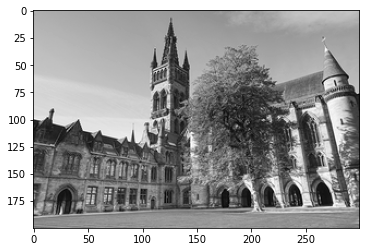

In [67]:
rx_byte = rx_byte[:60000].reshape(200, 300)
receive_img = Image.fromarray(rx_byte)
plt.imshow(receive_img, plt.cm.gray)

In [68]:
# calculate bit error ratio
origin_img = Image.open("DC4_300x200.pgm")
origin_img = np.array(origin_img)
ber = np.sum(origin_img != receive_img) / origin_img.size
print("Bit error ratio = ", ber)

Bit error ratio =  0.0
